In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
import scipy.io
import scipy.linalg

import sklearn.metrics
import sklearn.neighbors
from sklearn import metrics
from sklearn import svm

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

import ipdb

# Utils

In [15]:
def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )


def sliding_window(T, T_org, seq_len, label_seq_len):

    # seq_len is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
    TT_org = T_org.reshape(-1, 1)

    # TT has dim: n, 1
    # assemble the data into 2D
    x_set = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    y_set = np.vstack(TT_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert x_set.shape[0] == y_set.shape[0]

    # return size: n_samp, seq_len
    return x_set, y_set


def var_name(var, all_var=locals()):
    # get the name of the variable
    return [var_name for var_name in all_var if all_var[var_name] is var][0]


def np2csv(A):
    # store numpy to local csv file
    if type(A) == torch.Tensor:
        np.savetxt('./outputs/TCA/'+var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt('./outputs/TCA/'+var_name(A)+'.csv', A, delimiter=',')

# 1. TCA Part
## 1.a. Define TCA methodology

In [16]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K

In [17]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=1).reshape(-1, 1)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        L = L / np.linalg.norm(L, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))  # page 202
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, L, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        #ipdb.set_trace()
        Xs_new /= np.linalg.norm(Xs_new, axis=0)
        Xt_new /= np.linalg.norm(Xt_new, axis=0)
        return Xs_new, Xt_new, A

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

## 1.b. Load Data

In [18]:
weekdays = np.array([np.arange(2+7*i,7+7*i,1) for i in range(4)]).flatten()
weekends = np.array([np.arange(7+7*i,9+7*i,1) for i in range(3)]).flatten()[:-1]

src_domain = np.array(pd.read_csv('../TCA_traffic/data/siteM4_2168B_20210101_20210131.csv'))[np.array([5,6,7,8]), :]
data_target = np.array(pd.read_csv('../TCA_traffic/data/siteM4_2188B_20210101_20210131.csv'))[20:25, :]

date_choosen = 10
num_test_day = 4
#tar_domain = data_target[weekdays[date_choosen:date_choosen+1 + num_test_day], :].reshape(-1, 96)
tar_domain = data_target.copy()
tgt_validation = tar_domain[1:num_test_day+1, :]

Xs = normalize(src_domain.flatten())
Xt = normalize(tar_domain.flatten())

## 1.d. Hyperparameters

In [19]:
label_seq_len = 1
# batch_size = full batch
seq_len = 10
reduced_dim = 1
inp_dim = seq_len
label_dim = seq_len
hid_dim = 64
layers = 3
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

In [20]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,10,10,1,10,1,64,3,3


## 1.e. Apply BDA and get $Xs_{new}$, $Xt_{new}$ 

In [21]:
Xs, Ys = sliding_window(Xs, Xs, seq_len, label_seq_len)
Xt, Yt = sliding_window(Xt, Xt, seq_len, label_seq_len)

inp_dim -= reduced_dim
label_dim -= reduced_dim

C:\Users\10169\.conda\envs\bda_traff\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()
C:\Users\10169\.conda\envs\bda_traff\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [22]:
Xs.shape

(374, 10)

In [23]:
tca = TCA(kernel_type='linear', dim=inp_dim, lamb=lamb, gamma=1)
Xs_new, Xt_new, A = tca.fit(Xs, Xt)  # input shape: ns, n_feature | ns, 1
Xt_new_valid = Xt_new.copy()[int(96):, :]
Xt_new = Xt_new.copy()[:int(96), :]
Yt_valid = Yt.copy()[int(96):, :]
Yt = Yt.copy()[:int(96), :]

print(Xs_new.shape)
print(Xt_new.shape)
print(Xt_new_valid.shape)

np2csv(Xs_new)
np2csv(Xt_new)

(374, 9)
(96, 9)
(374, 9)


# 2. Learning Part

## 2.a. Build network

In [24]:
class LSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(LSTM, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.3, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim*2),
            nn.ReLU(),
            nn.Linear(hid_dim*2, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (batchsize, seq_len, input_dim)
        # output: (batchsize, seq_len, hid_dim)
        #ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = self.fc(y[:, :, :])  # fully connected layer
        
        return y[:, -1, :]

## 2.b. Assemble Dataloader

In [25]:
Xt_new.shape

(96, 9)

In [26]:
batch_size = 960

train_x = np.vstack([Xs_new, Xt_new])[:, :, np.newaxis]
train_y = np.vstack([Ys, Yt])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
Xt_new_valid = torch.tensor(Xt_new_valid[:, :, np.newaxis], dtype=torch.float32).to(device)
Yt_valid = torch.tensor(Yt_valid, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
train_iter = iter(train_loader)

## 2.c. Learn

In [27]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(1, 1, hid_dim, layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)

In [29]:
# train
net.train()

epoches = 1000
train_loss_set = []
val_loss_set = []

for e in range(epoches):
    for i in range(len(train_loader)):
        try:
            data, label = train_iter.next()
        except:
            train_iter = iter(train_loader)
            data, label = train_iter.next()
        
        out = net(data)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        val_out = net(Xt_new_valid)
        val_loss = criterion(val_out, Yt_valid)
        
        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
    if e%20==0:
        print('Epoch No. %i success, loss: %.5f, val loss: %.5f'%(e, loss.cpu().detach().numpy(), val_loss.cpu().detach().numpy()))

Epoch No. 0 success, loss: 0.15561, val loss: 0.09708
Epoch No. 20 success, loss: 0.04964, val loss: 0.04342
Epoch No. 40 success, loss: 0.04865, val loss: 0.04429
Epoch No. 60 success, loss: 0.04864, val loss: 0.04138
Epoch No. 80 success, loss: 0.04841, val loss: 0.04156
Epoch No. 100 success, loss: 0.04845, val loss: 0.04210
Epoch No. 120 success, loss: 0.04854, val loss: 0.04206
Epoch No. 140 success, loss: 0.04849, val loss: 0.04202
Epoch No. 160 success, loss: 0.04839, val loss: 0.04185
Epoch No. 180 success, loss: 0.04824, val loss: 0.04181
Epoch No. 200 success, loss: 0.04489, val loss: 0.03923
Epoch No. 220 success, loss: 0.01887, val loss: 0.01439
Epoch No. 240 success, loss: 0.01227, val loss: 0.00987
Epoch No. 260 success, loss: 0.00912, val loss: 0.00790
Epoch No. 280 success, loss: 0.00695, val loss: 0.00599
Epoch No. 300 success, loss: 0.00595, val loss: 0.00550
Epoch No. 320 success, loss: 0.00557, val loss: 0.00479
Epoch No. 340 success, loss: 0.00474, val loss: 0.0046

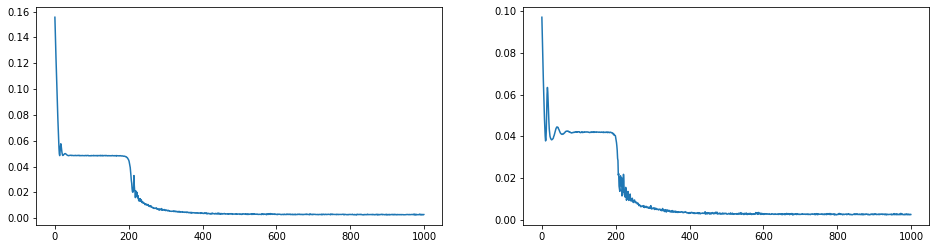

In [30]:
fig = plt.figure(figsize = [16, 4])
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_set)
ax2 = fig.add_subplot(122)
ax2.plot(val_loss_set)

# 3. Evaluation

In [31]:
def mape_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask = labels > .05
    return np.mean(np.fabs(labels[mask]-preds[mask])/labels[mask])

def smape_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask= labels > .05
    return np.mean(2*np.fabs(labels[mask]-preds[mask])/(np.fabs(labels[mask])+np.fabs(preds[mask])))

def mae_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask= labels > .05
    return np.fabs((labels[mask]-preds[mask])).mean()

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    return c

In [32]:
net.eval()

print('MAPE: %.5f'%mape_loss_func(val_out, Yt_valid))
print('SMAPE: %.5f'%smape_loss_func(val_out, Yt_valid))
print('MAE: %.5f'%mae_loss_func(val_out, Yt_valid))

MAPE: 0.16215
SMAPE: 0.16493
MAE: 0.03964
